<a href="https://colab.research.google.com/github/demirelilker/TermProject_Group24/blob/master/TermProject_NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import necessary packages.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms

from PIL import Image
import matplotlib.pyplot as plt

import copy

#Connect to google drive to import the content and the style images.

In [0]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use gpu if available

# Image Pre-processing & Loading
1. Zero pad the image so it will be square-shape.
2. Resize the image to (`im_size`, `im_size`).
3. Transfer the image tensor to CUDA.

In [0]:
im_size = 512

im_transform = transforms.Compose([
    transforms.Resize(im_size),
    transforms.ToTensor()]) 


def zero_pad(im_path):
    dummy_im = Image.open(im_path).convert('RGB')
    w, h = dummy_im.size
    new_size = max(w, h)
    new_im = Image.new('RGB', (new_size, new_size), (0, 0, 0))
    new_im.paste(dummy_im, (int((new_size - w) / 2), int((new_size - h) / 2)))
    return new_im

def im_loader(im):
    im = im.convert('RGB')
    im = im_transform(im).unsqueeze(0)
    im = im.to(device, torch.float)
    return im


def imshow(im, title):
    im = transforms.ToPILImage()(im.cpu().clone().squeeze(0)) 
    plt.imshow(im)

# Content Loss
1. Content loss is simply Mean-Squared Error (MSE) loss.
2. Wrap it around a class that inherits nn.Module.
3. Now we can use `.backward()` to calculate the gradients. 

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, content):
        super(ContentLoss, self).__init__()
        self.content = content.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.content)
        return input

# Style Loss
1. We will follow the same steps as in Content Loss.
2. Only now, we will calculate the MSELoss between *gram matrices* (style representations).
3. So, we first calculate the gram matrices.

In [0]:
def gram_matrix(input):
    b_size, num_filters, h, w = input.size() 
    features = input.view(b_size*num_filters, h * w)  

    gram = torch.mm(features, features.t())  # gram prod
    gram = gram.div(b_size*num_filters*h*w)  # gram

    return gram

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, style_feature):
        super(StyleLoss, self).__init__()
        self.style = gram_matrix(style_feature).detach()

    def forward(self, input):
        gram = gram_matrix(input)
        self.loss = F.mse_loss(gram, self.style)
        return input

# Importing vgg19 and getting ready to use it
1. Import the vgg19 model.
2. Define `vgg_mean` and `vgg_std`.
3. Normalize the images before sending them to vgg19 (these are the normalization values that the network was trained with).
4. Wrap this normazaliton process via a class inheriting nn.Module, so we can include it inside nn.Sequential.


In [0]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

vgg_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)  # Cx1x1, direct tensor operation
        self.std = torch.tensor(std).view(-1, 1, 1)  # Cx1x1, direct tensor operation

    def forward(self, im):  # normalize the image tensor.
        return (im - self.mean) / self.std

# Feature Extraction and Loss Calculations
1. Define the content and the style layers as in the original paper.
2. Extract the style and the content representations of the produced image.
3. Calculate the content and the style losses using the classes defined above.
4. Return the model, the content loss, and the style loss.
5. Since we have included the loss calculations, normalization and everything in the `model`, we will use that model to update losses simply by passing the image through the model, and benefitting the `.backward()` function to calculate the gradients, and `nn.Sequential` structure.

In [0]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_losses(vgg19, mean, std, style_im, content_im,
               content_layers=content_layers,
               style_layers=style_layers):
    
    vgg19 = copy.deepcopy(vgg19)
    normalization = Normalization(mean, std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in vgg19.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_' + str(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_' + str(i)
            layer = nn.ReLU(inplace=False)  # suggested
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_' + str(i)
        else:
            print('Not a viable option')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_im).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_im).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    # lose the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Neural Style Transfer Algorithm
1. Return the model, and the initial losses (remember losses are bounded to model!).
2. Define the optimizer. We use LBFGS.
3. Assert the input is clamped to `[0, 1]`
4. `optimizer.zero_grad()` resets the gradients back to zero for the next step.
5. `model(input_im)` passes the image through the model, to obtain the new loss values.
6. Style and content scores are calculated by weighting the losses (governs whether the content or the style will be preserved more).
7. `loss.backward()` calculates the gradients.
8. Image is updated by `optimizer.step(gradients)`.

In [0]:
def transform_the_image(vgg19, mean, std, content_im, style_im, input_im,
                       num_steps=500, style_weight=100000, content_weight=1):
    
    model, style_losses, content_losses = get_losses(vgg19, mean, std,
                                                     style_im, content_im)
    
    optimizer = optim.LBFGS([input_im.requires_grad_()])

    run = [0]
    while run[0] <= num_steps:

        def grad_descent():
            # correct the values of updated input image
            input_im.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_im)
            style_score = 0
            content_score = 0

            for style_loss in style_losses:
                style_score += style_loss.loss
            for content_loss in content_losses:
                content_score += content_loss.loss

            loss = style_score*style_weight + content_score*content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:2f} Content Loss: {:2f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(grad_descent)

    input_im.data.clamp_(0, 1)

    return input_im

# Load the style and the content images.

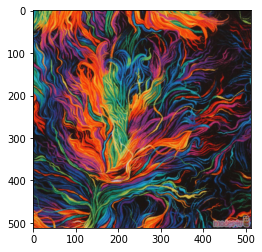

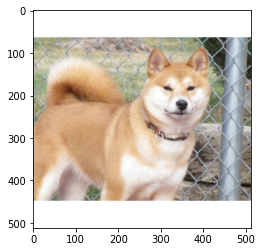

In [0]:
style_im = im_loader(zero_pad('/content/drive/My Drive/CS464_TermProject/style.jpg'))
content_im = im_loader(zero_pad('/content/drive/My Drive/CS464_TermProject/content.png'))

plt.figure()
imshow(style_im, title='Style Image')

plt.figure()
imshow(content_im, title='Content Image')

# Run the Neural Style Transfer algorithm and plot the resulting image.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


run [100]:
Style Loss : 0.000334 Content Loss: 34.137589

run [200]:
Style Loss : 0.000103 Content Loss: 32.677368

run [300]:
Style Loss : 0.000046 Content Loss: 30.369778

run [400]:
Style Loss : 0.000030 Content Loss: 29.061329

run [500]:
Style Loss : 0.000183 Content Loss: 27.651516



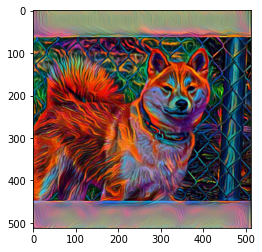

In [0]:
final_image = transform_the_image(vgg19, vgg_mean, vgg_std,
                                  content_im, style_im, content_im.clone())

plt.figure()
imshow(final_image, title='Final Image')

plt.show()